# Event Rate

There is no code available to display currently... 

In [4]:
import numpy as np
import math
import cmath
import matplotlib.pyplot as plt
import sympy as sp
import time
import concurrent.futures
from multiprocessing import Pool
from scipy import integrate
from scipy.integrate import quad
from scipy.optimize import curve_fit
from scipy.stats import skewnorm
from scipy.interpolate import interp1d
from scipy.optimize import fsolve

from astropy import units as u
from astropy.constants import G, c, M_sun, R_sun, L_sun, au, pc
from astropy.cosmology import WMAP9 as cosmo
from astropy.cosmology import FlatLambdaCDM
from pycbc.waveform import get_td_waveform
from pycbc.filter import matched_filter
from pycbc.psd import aLIGOZeroDetHighPower
from pycbc.noise import noise_from_psd
from pycbc.noise import frequency_noise_from_psd
from pycbc.types import FrequencySeries
from tabulate import tabulate
from matplotlib import rcParams
config = {
            "font.family": 'serif',
            "font.size": 12,
            "mathtext.fontset": 'stix',
            "font.serif": ['Times New Roman'],
            'axes.unicode_minus': False
         }
rcParams.update(config)

### 1. Distribution function fit

* **Distorted Gaussian distribution**

  
Here I attempted a simple skewed Gaussian for curve fitting.

The fitting performance was generally unsatisfactory, exhibiting substantial deviations in both the mean value and the tail of the distribution.

In [6]:
# Data
# model III, data from fig.4    
x3 = [0, 0.6, 1.0, 1.3, 1.5, 2.0, 2.3, 2.85, 3.0, 3.3, 3.5, 4.0, 5.0]
y3 = [80, 250, 380, 500, 575, 680, 750, 800, 750, 500, 250, 75, 0]

x4 = [0.0, 0.55, 1.0, 1.1, 2.0, 2.85, 3.0, 3.35, 3.5, 4.0, 5.0]
y4 = [50, 125, 200, 250, 375, 440, 375, 250, 125, 20, 0]

x5 = [0.0, 0.1, 0.5, 0.75, 1.0, 1.4, 1.5, 1.65, 2.0, 2.65, 3.0, 3.1, 3.2, 3.3, 3.4, 3.45, 3.55, 3.65, 4.0, 5.0]
y5 = [190, 250, 500, 750, 950, 1250, 1350, 1500, 1685, 2000, 1875, 1750, 1500, 1250, 1000, 750, 500, 250, 60, 0]

In [5]:
def distorted_gaussian(x, amp, mu, sigma, skew):
    gauss = amp * np.exp(-(x - mu)**2 / (2 * sigma**2))
    return gauss * (1 + skew * (x - mu))

def fit_gf(x, y):
    pgf, _ = curve_fit(distorted_gaussian, x, y, p0=[800, 3, 1, 1])
    x_gf = np.linspace(0, 5, 100)
    y_gf = distorted_gaussian(x_gf, *pgf)
    return x_gf, y_gf

x3_gf, y3_gf = fit_gf(x3, y3)
x4_gf, y4_gf = fit_gf(x4, y4)
x5_gf, y5_gf = fit_gf(x5, y5)

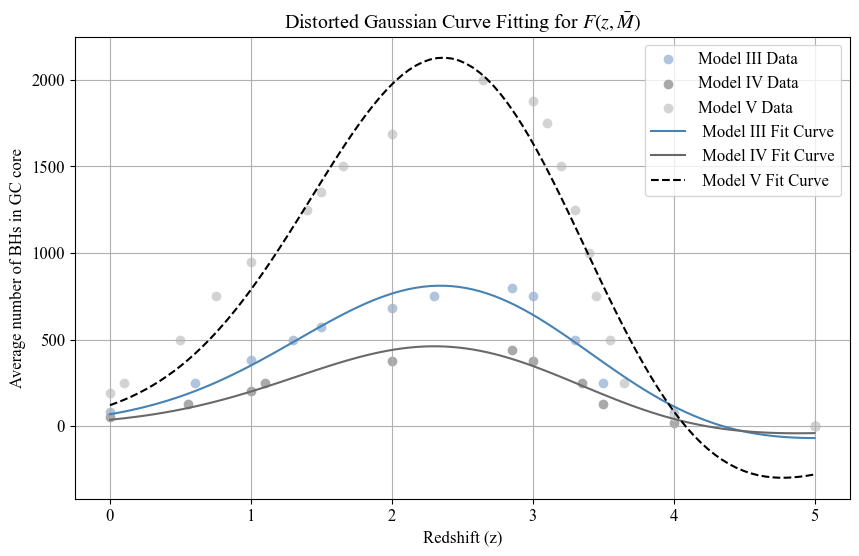

In [6]:
plt.figure(figsize=(10, 6))
plt.scatter(x3, y3, label='Model III Data', color='lightsteelblue')
plt.scatter(x4, y4, label='Model IV Data', color='darkgrey')
plt.scatter(x5, y5, label='Model V Data', color='lightgrey')
plt.plot(x3_gf, y3_gf, label=' Model III Fit Curve', color='steelblue')
plt.plot(x4_gf, y4_gf, label=' Model IV Fit Curve', color='dimgrey')
plt.plot(x5_gf, y5_gf, label=' Model V Fit Curve', color='black', linestyle = '--')
plt.legend()
plt.grid()
plt.xlabel(r'Redshift (z)')
plt.ylabel('Average number of BHs in GC core')
plt.title(r'Distorted Gaussian Curve Fitting for $F(z, \bar{M})$')
plt.show()

* **Skewed Normal Distribution**

  

In [20]:
def skewnorm_gaussian(x, a, loc, scale, amp):
    return amp * skewnorm.pdf(x, a, loc, scale)

def fit_sn(x, y):
    psn, _ = curve_fit(skewnorm_gaussian, x, y, p0=[1, 2, 1, 800])
    x_sn = np.linspace(0, 5, 100)
    y_sn = skewnorm_gaussian(x_sn, *psn)
    return x_sn, y_sn, psn

x3_sn, y3_sn, psn3 = fit_sn(x3, y3)
x4_sn, y4_sn, _ = fit_sn(x4, y4)
x5_sn, y5_sn, psn5 = fit_sn(x5, y5)

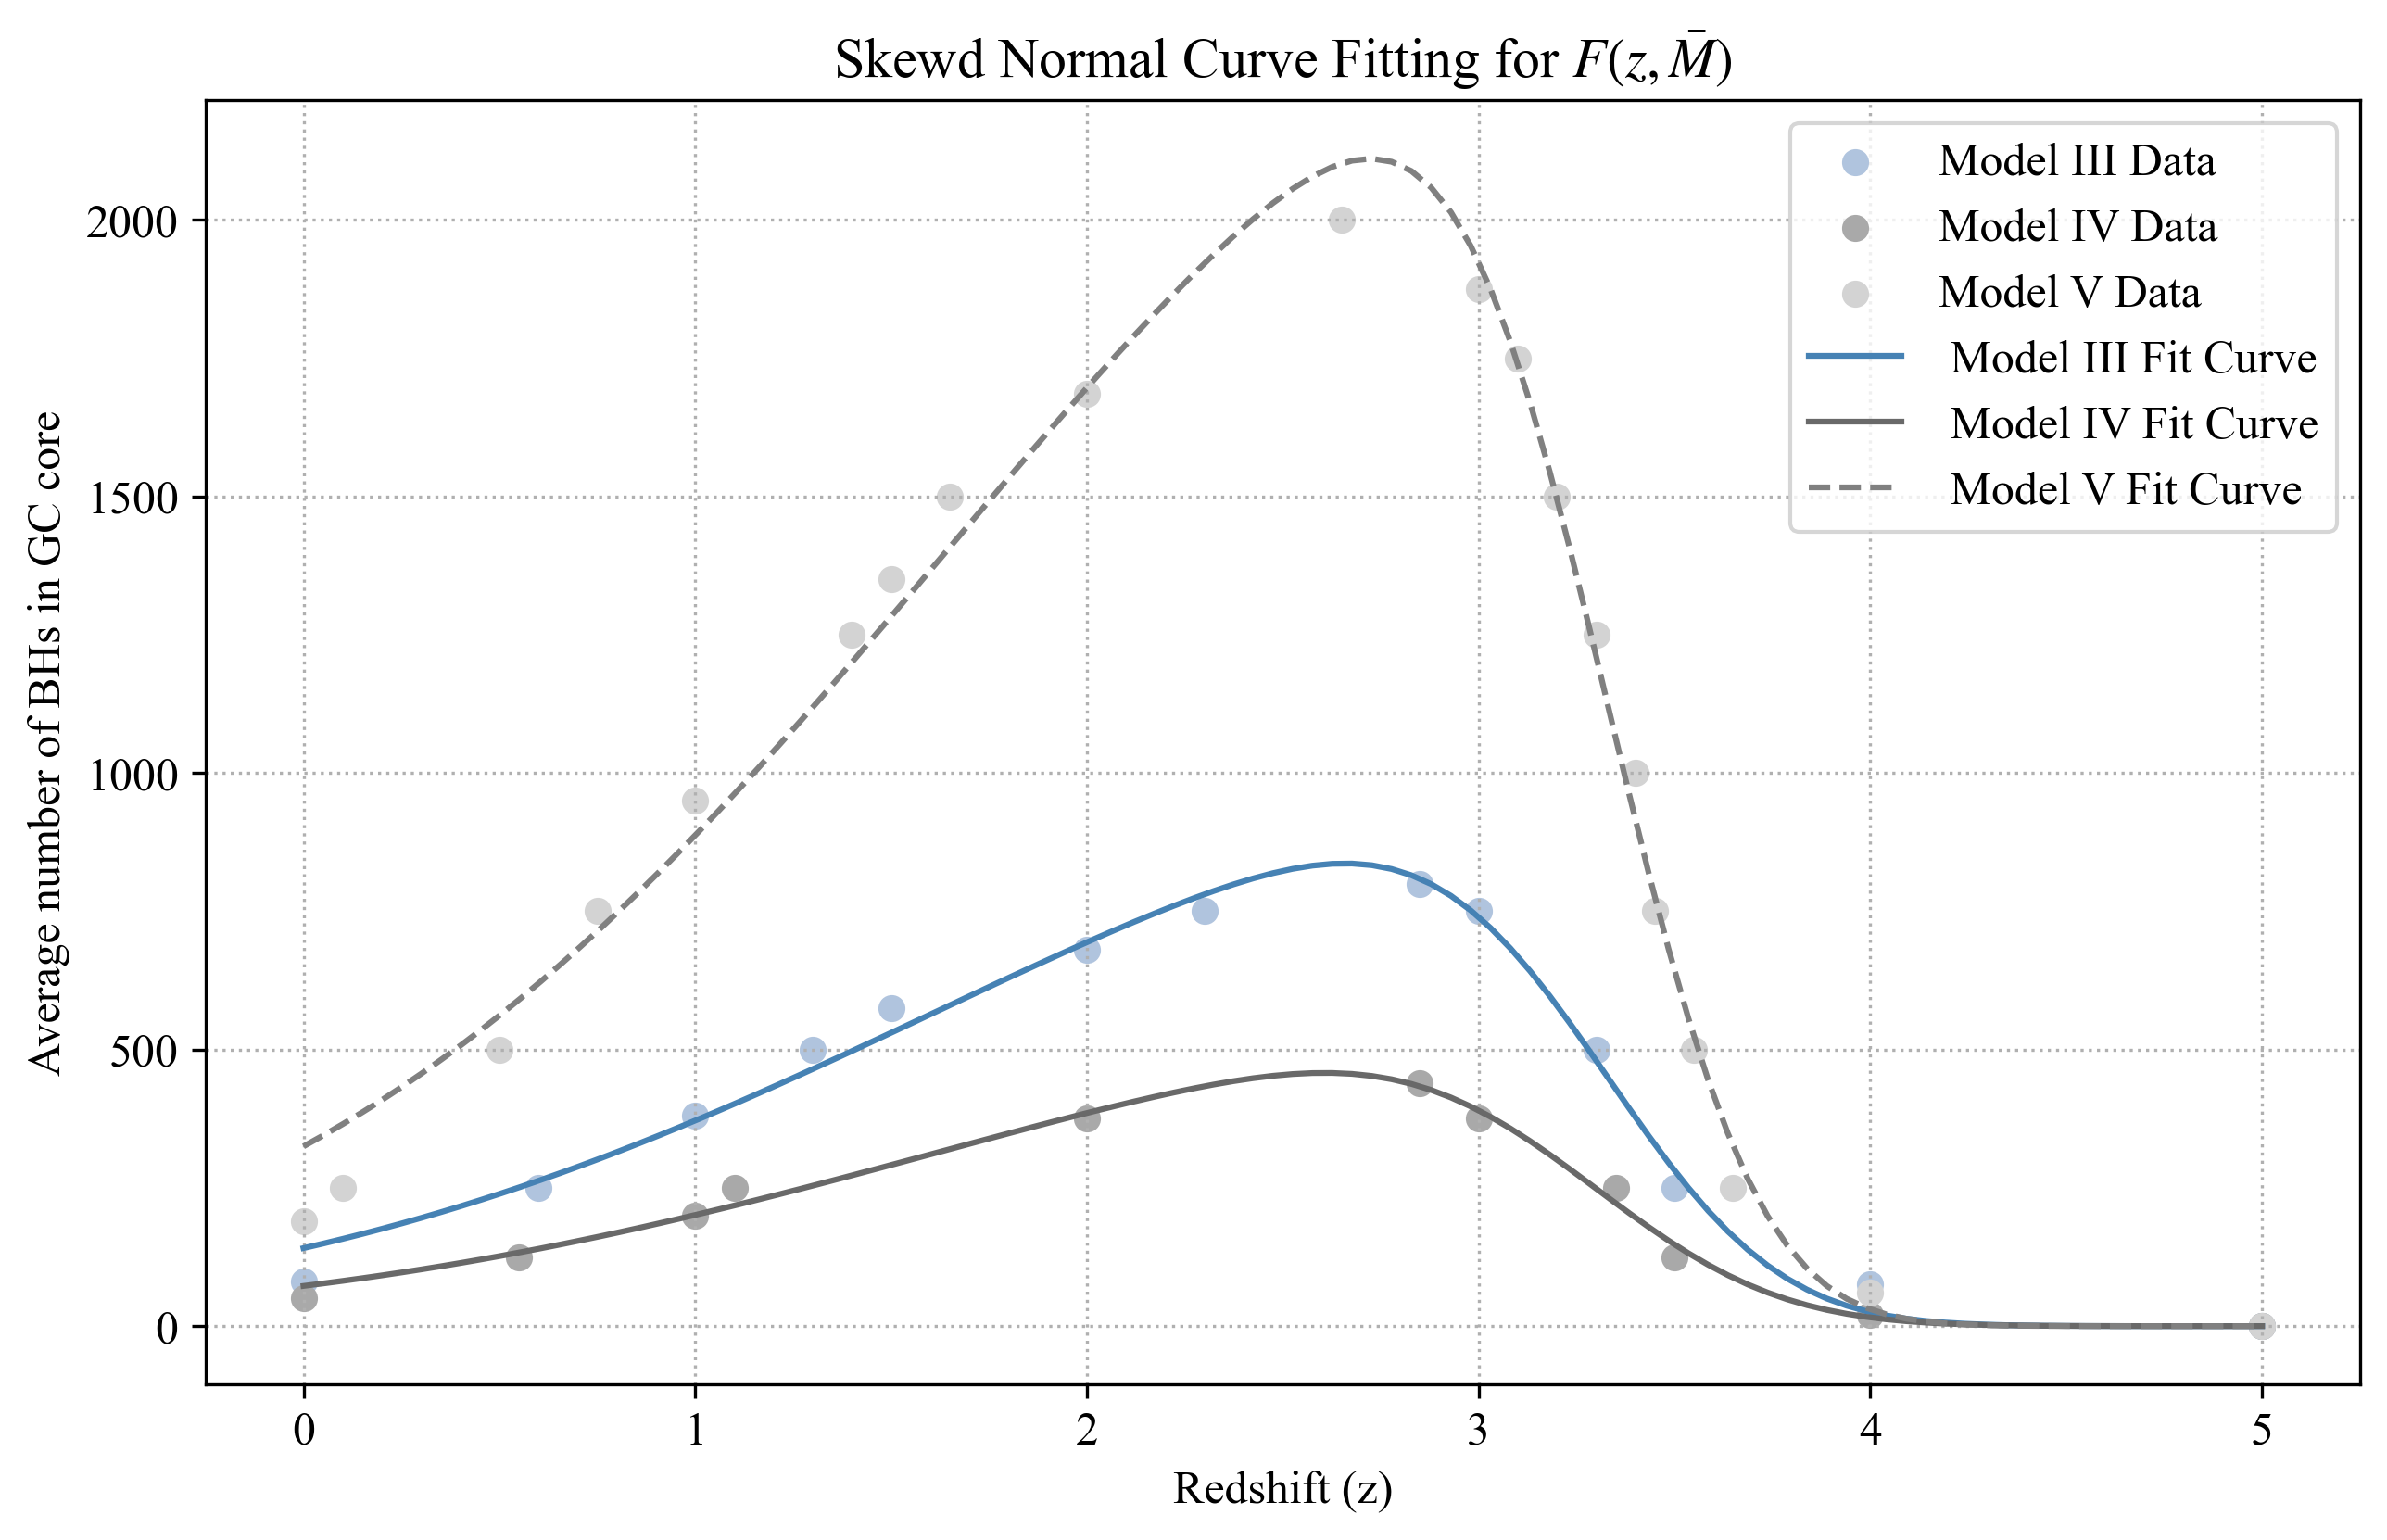

In [22]:
plt.figure(figsize=(10, 6), dpi =300)
plt.scatter(x3, y3, label='Model III Data', color='lightsteelblue')
plt.scatter(x4, y4, label='Model IV Data', color='darkgrey')
plt.scatter(x5, y5, label='Model V Data', color='lightgrey')
plt.plot(x3_sn, y3_sn, label=' Model III Fit Curve', color='steelblue')
plt.plot(x4_sn, y4_sn, label=' Model IV Fit Curve', color='dimgrey')
plt.plot(x5_sn, y5_sn, label=' Model V Fit Curve', color='grey', linestyle = '--')
plt.legend()
plt.grid(linestyle = ':')
plt.xlabel(r'Redshift (z)')
plt.ylabel('Average number of BHs in GC core')
plt.title(r'Skewd Normal Curve Fitting for $F(z, \bar{M})$')
# plt.savefig('sn_nco.png')
plt.show()

In [12]:
psn3

array([-4.68658436e+00,  3.31272209e+00,  1.70338724e+00,  1.99421984e+03])

### Calculations

initial velocity

comoving distance

the number of galaxy

注意在公式计算的时候，单位换算很重要，如果是 astropy.constants 库里的，会帮你自动换算成m/s，
但是注意units 库里的不会自动换算，比如Mpc，需要手动转换一下。


* 定义一些常见的天文常数和单位
  
```python
    distance_au = 1 * au  # 1 AU
    
    distance_ly = 1 * ly  # 1 光年

    distance_pc = 1 * pc  # 1 秒差距
    
    mass_sun = 1 * M_sun  # 1 太阳质量

    radius_sun = 1 * R_sun  # 1 太阳半径

    luminosity_sun = 1 * L_sun  # 1 太阳光度

```

In [24]:
# constant lsit
m1 = 10*M_sun                # the mass of the CO
m2 = 10*M_sun                # the mass of the CO
M = m1+m2                    # the total mass
R_cluster = 10*pc            # the radius of the cluster
R_co = 0.5*pc                # the radius of the dense core of the cluster
n_gc = 200                   # the number of GC per MWEG
n_z = 0.0116*(u.Mpc**(-3))   # the number density of MWEG at different redshift
n_z = n_z.to(u.m**-3)
omega_L = 0.685              # standard cosmological parameters
omega_m = 0.315
H0 = cosmo.H0.to(u.s**-1)
cosmo = FlatLambdaCDM(H0=67.4, Om0=0.315, Tcmb0=2.7255)


In [26]:
z = np.linspace(0.0002, 5.0, 1000)

# vi, according to the Virial Theorem
def initial_velocity(n_star, m, R_cluster):
    # n_star : the number of the stars in the cluster
    # m : the average mass of a star
    # R_cluster : the radius of the cluster
    return np.sqrt(G*n_star*m/3/R_cluster)

# 1/E(z), according to the flat universe
def inverse_Hubble_parameter(zz):
    return 1./np.sqrt(omega_L+omega_m*(1+zz)**3)

# 2 different ways to calculate comoving distance
# comoving distance calculated according to the definition
def comoving_r(zz):
    r, _ = quad(inverse_Hubble_parameter, 0.0002, 5.0)
    return (c/H0*r).to(u.Mpc)

# directly using the astropy
def comoving_distance(zz):
    r = cosmo.comoving_distance(zz)
    return r.to(u.m)

# time dilation
def time_dilation(zz):
    zz = zz * u.dimensionless_unscaled
    t = 1. / (1 + zz)
    t = t*u.s
    return t

# N(z), the number of galaxies at different redshift
def number_galaxy(zz):
    return 4*np.pi/H0*comoving_distance(zz)**2*c*n_z*inverse_Hubble_parameter(zz)

# n_co(z), the number of the compact objects in one GC core
# Here we use the distribution f(z,M)
def number_co(zz, psn):
    return skewnorm_gaussian(zz, *psn)

def impact_parameter(m, vi, ri, theta_i):
    rs = 2*G*m/c**2
    # using the approximation, e \sim 1
    bmin = 2*np.sqrt(G*2*m*rs)/vi # here the mass should be the total mass
    bmin = bmin.to(u.m)
    bmax = ri*theta_i
    bmax = bmax.to(u.m)
    return bmax**2-bmin**2

def prob_cluster(vi, zz, psn, m, ri, theta_i):
    const1 = 3*vi*impact_parameter(m, vi, ri, theta_i)/4/R_co**3
    const2 = np.log(R_co/R_co)
    return const1*number_co(zz, psn)**2*(const2+(1/3)*np.log(number_co(zz, psn)))

def number_event(vi, zz, psn, m, ri, theta_i):
    return 3.1536*10**7*time_dilation(zz)*prob_cluster(vi, zz, psn, m, ri, theta_i)*n_gc*number_galaxy(zz)

def prob_total(vi, zz, psn, m, ri, theta_i):
    ptotal = lambda zz: number_event(vi, zz, psn, m, ri, theta_i)
    event_rate, _ = quad(ptotal, 0.0002, zz[-1])
    return event_rate

In [28]:
vi_norm = initial_velocity(8*10**5, 1*M_sun, 10*pc)
vi_V = initial_velocity(1.6*10**6, 1*M_sun, 10*pc)

cr1 = comoving_r(z)
cr2 = comoving_distance(z)
cr1,cr2[-1]**2, c/H0, vi_norm, vi_V

(<Quantity 7945.11726789 Mpc>,
 <Quantity 6.00796629e+52 m2>,
 <Quantity 1.37249683e+26 m>,
 <Quantity 10709.39434333 m / s>,
 <Quantity 15145.37072514 m / s>)

In [30]:
"""
For Model III,

initial velocity is the normal one vi_nrom = 10.69 km/s
psn3 is the parameter for skew norm distribution
m1, ri, theta_i are the parameters for calculating the b^2

"""
event3_CE2 = number_event(vi_norm, z, psn3, m1, 0.5*pc, 0.1*au/0.5/pc)
event3_ETD = number_event(vi_norm, z, psn3, m1, 0.5*pc, 5.5*10**-7)
event3_Aplus = number_event(vi_norm, z, psn3, m1, 0.5*pc, 3.0*10**-7)

event5_Aplus = number_event(vi_V, z, psn5, m1, 0.5*pc, 3.0*10**-7)
event5_ETD = number_event(vi_V, z, psn5, m1, 0.5*pc, 5.5*10**-7)

ptotal3_CE2 = prob_total(vi_norm, z, psn3, m1, 0.5*pc, 0.1*au/0.5/pc)
ptotal3_ETD = prob_total(vi_norm, z, psn3, m1, 0.5*pc, 5.5*10**-7)
ptotal3_Aplus = prob_total(vi_norm, z, psn3, m1, 0.5*pc, 3.0*10**-7)

ptotal5_ETD = prob_total(vi_norm, z, psn5, m1, 0.5*pc, 5.5*10**-7)
ptotal5_Aplus = prob_total(vi_norm, z, psn5, m1, 0.5*pc, 3.0*10**-7)

ptotal3_CE2, ptotal3_ETD, ptotal3_Aplus, ptotal5_ETD, ptotal5_Aplus

headers = [" ", "Model III", "", "Model V", ""]
rows = [
    ["ETD", ptotal3_ETD, 0.44, ptotal5_ETD, 2.23],
    ["A+", ptotal3_Aplus, 0.14, ptotal5_Aplus, 0.70],
    ["CE2", ptotal3_CE2, 1.38, "", ""]]
print(tabulate(rows, headers, tablefmt="rst"))

====  ===========  ====  ==================  ====
..      Model III        Model V
====  ===========  ====  ==================  ====
ETD       4.18574  0.44  29.2609344606686    2.23
A+        1.1293   0.14  7.8945150988400865  0.7
CE2      13.3576   1.38
====  ===========  ====  ==================  ====


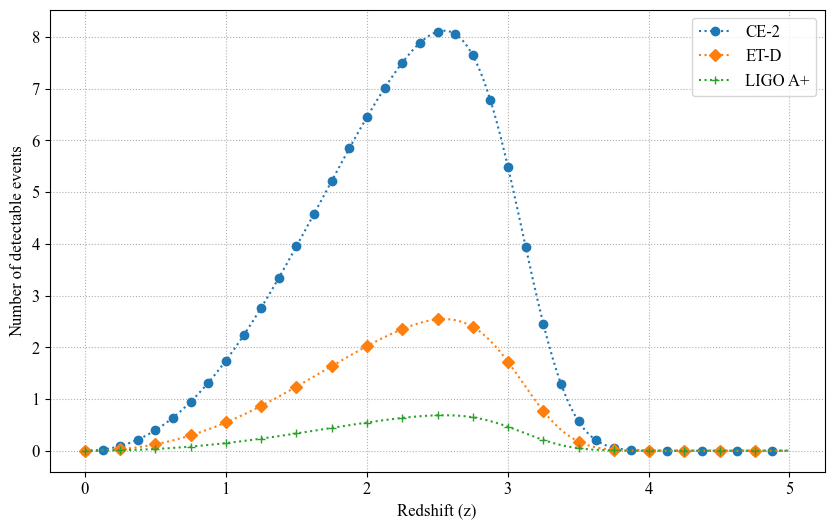

In [188]:
plt.figure(figsize=(10, 6))
plt.plot(z, event3_CE2, linestyle=':', marker='o', markevery=25, label='CE-2')
plt.plot(z, event3_ETD, linestyle=':', marker='D', markevery=50, label='ET-D')
plt.plot(z, event3_Aplus, linestyle=':', marker='+', markevery=50, label='LIGO A+')
plt.grid(linestyle = ':')
plt.xlabel(r'Redshift (z)')
plt.ylabel('Number of detectable events')
plt.legend()
plt.show()


In [38]:
num_co = lambda zz: number_co(zz, psn3)
nco, _ = quad(num_co, 0.0002, 5.0)
nco
nco**2*(np.log(R_cluster/R_co)+(1/3)*np.log(nco))

<Quantity 19703180.23066381>

In [40]:
num_gal = lambda zz: number_galaxy(zz)
gal, _ = quad(num_gal, 0.0002, 5.0)
gal

24367623217.425415

In [420]:
# plt.plot(z, number_co(z,psn3))

In [422]:
bmax**2-bmin**2

<Quantity 2.22428313e+20 m2>

In [229]:
R_cluster**3

<Quantity 2.93799895e+52 m3>

In [231]:
np.log(R_cluster/R_co)

<Quantity 2.99573227>

In [267]:
n_z.to(u.m**-3)

<Quantity 3.94826554e-70 1 / m3>

In [777]:
c/H0

<Quantity 1.37249683e+26 m>

In [70]:
(0.9*u.Gpc**-3).to(u.m**-3)

<Quantity 3.06330947e-77 1 / m3>

In [444]:
n_z

<Quantity 3.94826554e-70 1 / m3>

In [775]:
R_co**3

<Quantity 3.67249868e+48 m3>

In [529]:
0.1*au

<Quantity 1.49597871e+10 m>

In [533]:
np.sin(1.5*10**-7*u.rad)

<Quantity 1.5e-07>

In [401]:
class gcluster:
# ----------------------------
# n_star : the number of the stars in the cluster
# m : the average mass of a star in the cluster
# R_cluster : the radius of the cluster
# R_core : the radius of the core of the cluster
# ....
# maybe the number of compact objects will be included here
# ----------------------------    
    def __init__(self, n_star, m, R_cluster, R_core):
        self.n = n_star
        self.m = m
        self.Rc = R_cluster
        self.Rco = R_core
    def initial_velocity(self):
        return np.sqrt(G*self.n*self.m/3/self.Rc)

class hyperbolic_orbit:
    def __init__(self, m1, m2, cluster, ri, theta_i):
        # mass
        self.m1 = m1
        self.m2 = m2
        self.M = m1+m2
        self.mu = m1*m2/(m1+m2)
        
        # initial conditions
        self.vi = cluster.initial_velocity()
        self.ri = ri
        self.theta_i = theta_i*u.rad
        
        # system set, coordinate
        self.L = self.ri*self.vi*np.sin(self.theta_i)
        self.phi = np.linspace(0, 2*np.pi, 1000)* u.rad 

        # hyperbola parameters
        self.b = self.ri*np.sin(self.theta_i)
        self.a = G*self.M/self.vi**2
        self.alpha = 1-2*self.a/self.ri
        self.beta = np.cos(self.theta_i)/(1-self.b**2/self.a/self.ri)
        self.p = self.L**2/(G*self.M)
        self.e = self.eccentricity()
        self.phi0 = self.periastron_angle()
        self.rp = self.periastron_distance()

    def eccentricity(self):
        return np.sqrt(1+self.alpha*self.b**2/self.a**2)

    def periastron_angle(self):
        tan_phi0 = -self.beta*self.b/self.a
        return np.arctan(tan_phi0)

    def periastron_distance(self):
        rp = self.L**2/G/self.M/(1+self.e)
        return rp

    def orbit_r(self):
        r_phi = self.p/(1+self.e*np.cos(self.phi-self.phi0))
        return r_phi

    def trans_cartesian(self):
        rr = self.orbit_r()
        x = rr*np.cos(self.phi-self.phi0)
        y = rr*np.sin(self.phi-self.phi0)
        return x, y

    def testphi(self):
        u = self.phi - self.phi0
        b = self.b.value
        v0 = self.vi.value
        e = self.e
        return b**2/v0/(e**2)*(e*np.sin(u)/(1+e*np.cos(u))-2*np.tan(u/2)/(e+1))

# way to get phi(t) with 3 analytical integral method 
    def phi_t(self):
        phi0 = self.phi0.value
        def function_of_functions(phi):
            #---------------Method A---------------------
            c1 = -2*self.p**2/(self.e**2-1)**(3/2)
            c2 = np.sqrt((self.e-1)/(self.e+1))
            c3 = self.e*self.p**2/(self.e**2-1)
            c1 = c1.value
            c2 = c2.value
            c3 = c3.value
            u = phi - phi0
            # print(c1,c2,c3)
            return c1*np.arctan(c2*np.tanh((u)/2))+c3*np.sin(u)/(1+self.e*np.cos(u))
            #----------------Method B--------------------
            #A = (self.e+1).value
            #B = (self.e-1).value
            #D = (self.p**2/self.L).value
            #u = np.tan((phi-phi0)/2)
            #return D*2*u/(A+(A+B*u**2))+np.arctan(np.sqrt(B/A)*u)/A/np.sqrt(B)
            #----------------Method C--------------------
            #b = self.b.value
            #v0 = self.vi.value
            #e = self.e
            #return b**2/v0/(e**2)*(e*np.sin(u)/(1+e*np.cos(u))-2*np.tan(u/2)/(e+1))
        

        def equation(t, phi):
            return t-function_of_functions(phi)
        
        time = np.linspace(-0.5, 0.5, 1000)
        phi = np.linspace(0, 2*np.pi, 1000)
        phi_solutions = np.zeros_like(time)
        for i, t in enumerate(time):
            phi_solutions[i] = fsolve(equation, x0 = phi[i], args = (t,))[0]

        return phi_solutions

# way to get t integrated by phi with two numerical integral
    def t_phase(self):
        def phifunc(angle):
            angle = angle*u.rad
            c = (self.p**2/self.L).value
            return c/(1+self.e*np.cos(angle-phi0))**2

        phi_values = np.linspace(self.phi0.value, 2*np.pi, 1000)
        result = np.zeros_like(phi_values)
        for i, phi in enumerate(phi_values):
            #result[i], _ = quad(phifunc, self.phi0.value, phi) 
            limit = np.linspace(self.phi0.value, phi, 1000)
            result[i] = integrate.cumulative_trapezoid(phifunc(phi_values), limit, initial = 0)[-1]
        #limit = np.linspace(self.phi0.value, 2*np.pi, 1000) 
        #result = integrate.cumulative_trapezoid(phifunc(phi_values), limit, initial = 0)
        return result




In [403]:
class hyperbolic_GW(hyperbolic_orbit):
    def __init__(self, m1, m2, cluster, ri, theta_i):
        super().__init__(m1, m2, cluster, ri, theta_i)

    def power_t(self):
        e = self.e
        mu = self.mu
        vi = self.vi
        alpha = self.alpha
        b = self.b
        phi = (super().phi_t())*u.rad
        phi0 = self.phi0
        cons = -32*G*(mu**2)*(alpha**4)*(vi**6)/45/(c**5)/b**2
        func = 3/8*(1+e*np.cos(phi-phi0))**4/(e**2-1)**4*\
                (24+13*e**2 + 48*e*np.cos(phi-phi0) + 11*e**2*np.cos(2*(phi-phi0)))
        return cons*func


    
# orbits parameters
# GW signals simulation
# psd
# calculate SNR, give the relation between theta_i and SNR

# class event_rate:

In [405]:
if __name__ == "__main__":
    n_star = 8*10**5
    m = 1*M_sun
    m1 = 10*M_sun
    m2 = 10*M_sun
    R_cluster = 10*pc
    R_co = 0.5*pc
    ri = 0.5*pc
    theta_i = 1.5*10**-7

    cluster = gcluster(n_star, m, R_cluster, R_co)
    orbit = hyperbolic_orbit(m1, m2, cluster, ri, theta_i)


In [563]:
if __name__ == "__main__":
    n_star = 8*10**5
    m = 1*M_sun
    m1 = 10*M_sun
    m2 = 10*M_sun
    R_cluster = 10*pc
    R_co = 0.5*pc
    ri = 0.5*pc
    theta_i = 1.5*10**-7

    cluster = gcluster(n_star, m, R_cluster, R_co)
    orbit = hyperbolic_orbit(m1, m2, cluster, ri, theta_i)

In [174]:
alpha = orbit.alpha
a = orbit.a
b = orbit.b
e = orbit.e
p = orbit.p
L = orbit.L
phi0 = orbit.phi0
r = orbit.orbit_r()

print(alpha, a, b, e, p, L, phi0, np.cos(phi0), p**2/L)

r_x = np.array(orbit.trans_cartesian()[0])
r_y = np.array(orbit.trans_cartesian()[1])

def hyperbola_curve(x, e, a, b):
    a = a/alpha
    b = b/np.sqrt(alpha)
    sert = (x-a*e)**2/a**2-1
    return b*np.sqrt(np.abs(sert)), -b*np.sqrt(np.abs(sert))

popt, _ = curve_fit(lambda x, e, a, b: hyperbola_curve(x, e, a, b)[0], r_x, r_y, p0=(1, 2*10**13, 2*10**9))
x_fit = np.linspace(-5*10**10, 0, 1000)
y_fit_positive, y_fit_negative = hyperbola_curve(x_fit, *popt)


0.997 23142581861185.25 m 2314258186.118517 m 1.000000004985 231425.81861185085 m 24784303527424.83 m2 / s -9.99999996681652e-05 rad 0.999999995 0.0021609608460815256 s


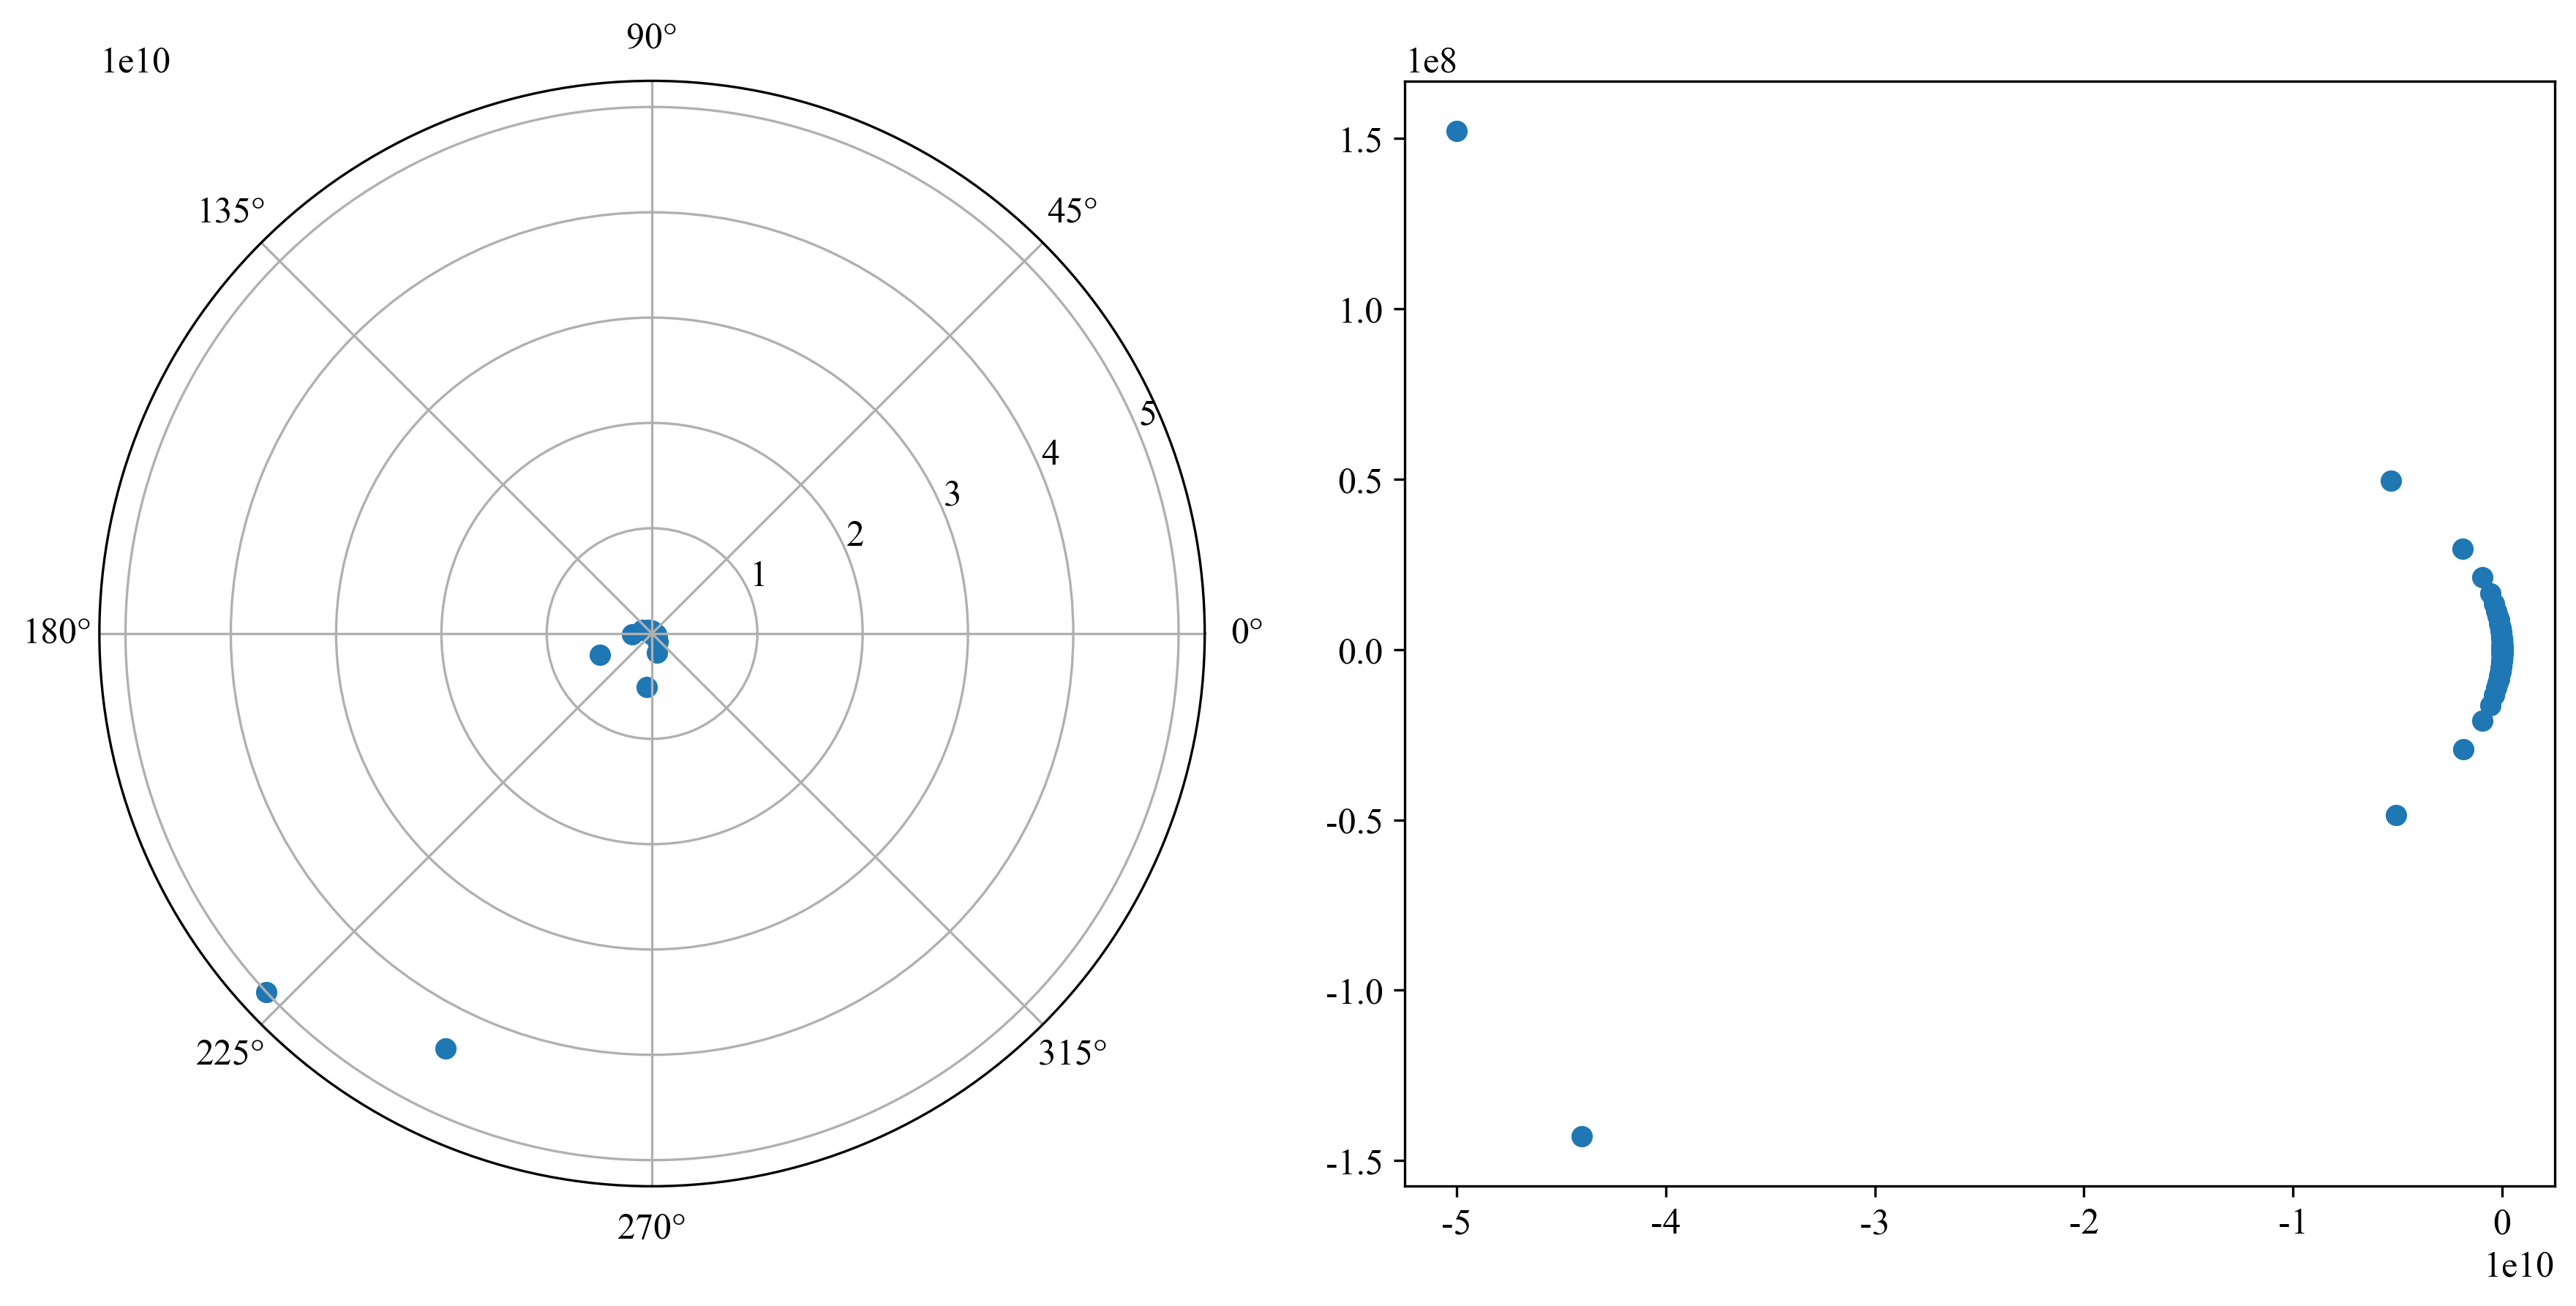

In [427]:
plt.figure(figsize=(12, 6), dpi = 300)
plt.subplot(121, projection='polar')
plt.scatter(orbit.phi.to(u.degree), r)

plt.subplot(122)
plt.scatter(r_x, r_y)
#plt.plot(x_fit, y_fit, label=f'Fit (degree {2})', color='r')
#plt.plot(x_fit, y_fit_positive, label='Fit (positive)', color='red')
#plt.plot(x_fit, y_fit_negative, label='Fit (negative)', color='blue')
plt.tight_layout()
plt.show()

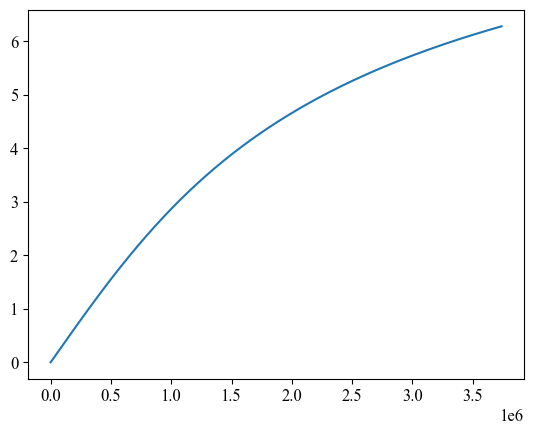

In [421]:
cluster = gcluster(n_star, m, R_cluster, R_co)
orbit = hyperbolic_orbit(m1, m2, cluster, ri, theta_i)
t = orbit.t_phase()
t2 = orbit.testphi()
#plt.plot(t, np.linspace(0, 2*np.pi, 1000))
plt.plot(t2, np.linspace(0, 2*np.pi, 1000))

/var/folders/0k/8k0xvpzs4tn3l4vh7h5bkplr0000gn/T/ipykernel_70183/3722348383.py:107: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  phi_solutions[i] = fsolve(equation, x0 = phi[i], args = (t,))[0]


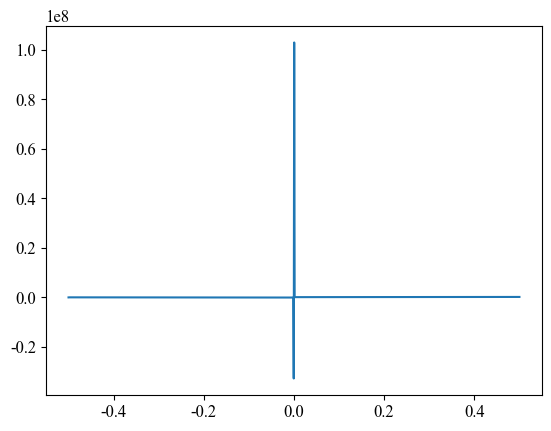

In [396]:
#phi = orbit.function_of_functions()
cluster = gcluster(n_star, m, R_cluster, R_co)
orbit = hyperbolic_orbit(m1, m2, cluster, ri, theta_i)
phi = orbit.phi_t()
plt.plot(np.linspace(-0.5, 0.5, 1000), phi)

/var/folders/0k/8k0xvpzs4tn3l4vh7h5bkplr0000gn/T/ipykernel_70183/2113407959.py:107: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  phi_solutions[i] = fsolve(equation, x0 = phi[i], args = (t,))[0]


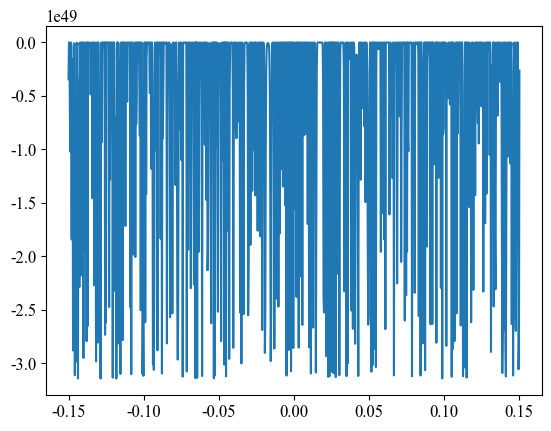

In [398]:
cluster = gcluster(n_star, m, R_cluster, R_co)
orbit = hyperbolic_orbit(m1, m2, cluster, ri, theta_i)
gw = hyperbolic_GW(m1, m2, cluster, ri, theta_i)
p = gw.power_t()
plt.plot(np.linspace(-0.15, 0.15, 1000), p)

* For the multiple process

(if need)


```python

    def task(test_wave, duration):
        print(f"Task {test_wave} started")
        time.sleep(duration)
        print(f"Task {test_wave} completed")
        return test_wave
    
    if __name__ == "__main__":
        with Pool(processes=2) as pool:
            results = [pool.apply_async(task, args=(f"Task {i}", i)) for i in range(1, 3)]
            
            for result in results:
                print(f"{result.get()} completed")
    
    def GWnoise(hp, psd):
        print("Starting noise calculation...")
        time.sleep(10)
        length = len(hp)
        dt = hp.delta_t
        psd = psd
        noise = noise_from_psd(length, dt, psd)
        print("Noise calculation completed.")
        return noise
    
    
    executor = concurrent.futures.ThreadPoolExecutor(max_workers=1)
    future = executor.submit(GWnoise, hp, psd)
    print("Task has been submitted. You can run other cells now.")

```

## Waveform and noise

In [80]:
thp = np.loadtxt('waveform.txt')
psd = np.loadtxt('psd.txt')
noise = np.loadtxt('noise.txt')

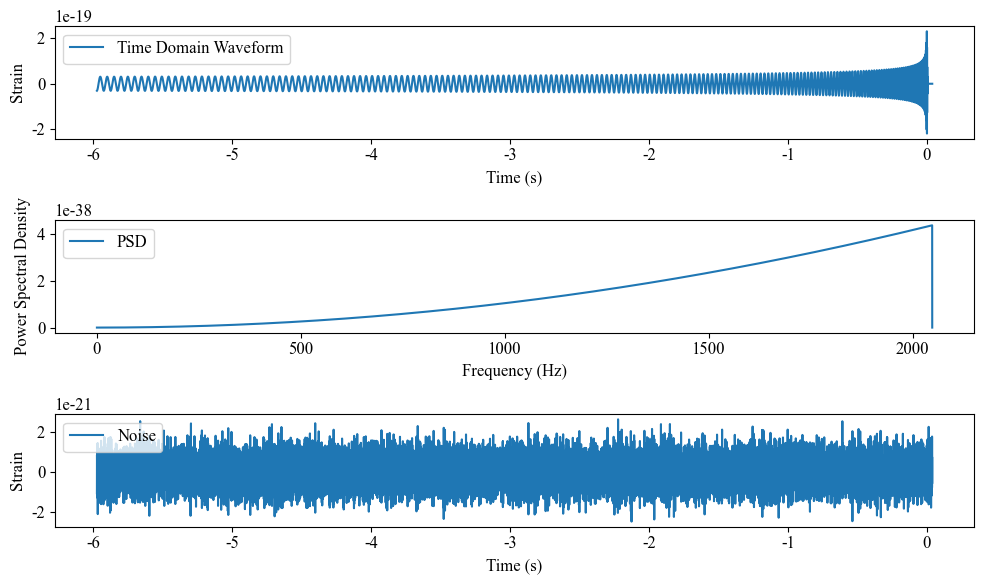

In [99]:
plt.figure(figsize=(10, 6))
plt.subplot(3, 1, 1)
plt.plot(hp.sample_times, thp, label='Time Domain Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(np.linspace(0, 1.0 / (2.0 * hp.delta_t), len(psd)), psd, label='PSD')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(hp.sample_times, noise, label='Noise')
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.legend()

plt.tight_layout()
plt.show()

In [193]:
2*np.pi

6.283185307179586